# Discretization in One Dimension

In [2]:
import matplotlib.pyplot as plt
import numpy as np

A helpful intuition in the study of Laplace's equation

$$
\nabla^2 V = 0
$$

is to realize that the solutions always have the averaging property. This property can even be turned into a numerical technique for solving Laplace’s equation, the method of relaxation. This is a delightful and accessible numerical technique for solving certain partial differential equations (PDEs) that we will work on in the next few notebooks.

In the end this method is very simple, but there are several numerical steps that won’t appear intuitive until you have derived them yourself. The main ingredient&mdash;to understand and develop notation for&mdash;is discretization. You've used discretization in solving Ordinary Differential Equations (ODEs), e.g. for Euler's method, and in plotting vector fields, but here we will focus on this process explicitly. 

## One-dimensional discretization

A discretization cuts a smooth, continuous space into pieces. At first we will always take these pieces to have the same size. A simple example is the elementary number line plotted below. The discretization chops the black line into a set of evenly spaced, red points.

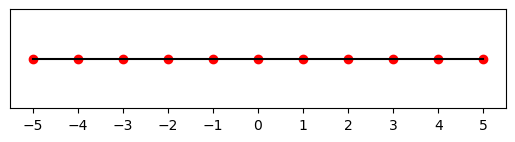

In [26]:
latticepts = np.linspace(-5,5,11) #Setup the points of the discretization
yvals = np.zeros_like(latticepts) #In 1D give them no y heights

fig, ax = plt.subplots() #Setup figure

ax.plot(latticepts,yvals,"ro",latticepts, yvals, '-k') #Make plot

ratio = 0.2 #The next few lines adjust the aspect ratio for our 1D plot
x_left, x_right = ax.get_xlim()
y_low, y_high = ax.get_ylim()
ax.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)

plt.xticks(latticepts) #Show ticks and labels at all lattice pts
plt.tick_params(left = False, labelleft = False) #Remove vertical ticks/labels

plt.show()

The idea of the discretization is to study the electric potential $V$ not at every point of the black line, but only at the discrete set of values denoted by the red points. It will be quite useful to have some notation that allows us to refer to the points of the discretization. If we think of the black line as the $x$-axis, then we can refer to an arbitrary red point using the symbol $x_i$. Here the subscript $i$ varies over the integers and picks out which lattice point we are referring to. The lattice points $x_{-4}$ and $x_{3}$ are shown in the plot below.

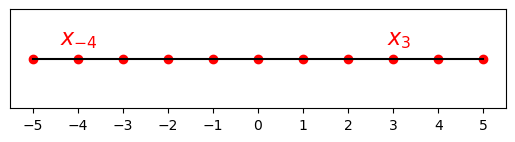

In [58]:
fig, ax = plt.subplots() #Same setup as above...

ax.plot(latticepts,yvals,"ro",latticepts, yvals, '-k') 
ax.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)
plt.xticks(latticepts) 
plt.tick_params(left = False, labelleft = False) 

#...but, this snippet adds text to the plot
ax.text(.76, 0.65, "$x_3$",c='red', fontsize=16, transform=ax.transAxes)
ax.text(.1, 0.65, "$x_{-4}$",c='red', fontsize=16, transform=ax.transAxes)

plt.show()

Using a bit of notational cleverness, we can also develop a shorthand for the value of the electric potential at the point $x_i$: we simply use the same subscript convention again and define $V_i \equiv V(x_i)$. It is much easier to do calculations with the compact expression $V_i$ than with the more cumbersome $V(x_i)$. 

Let's use this new notation to find a discrete approximation to the derivative $dV/dx$. At the point $x_i$, this derivative is defined by

$$
\frac{dV}{dx} = \lim_{h \rightarrow 0} \frac{V(x_i+h)-V(x_i)}{h}.
$$

To make a discrete approximation of this quantity we will simply drop the limit and take the step size $h$ to be fixed. In particular, this means that $x_i+h$ is one step to the right of $x_i$ and is $x_{i+1}$. Our approximation is then,

$$
\frac{dV}{dx} \approx \frac{V(x_{i+1})-V(x_i)}{h} = \frac{V_{i+1}-V_i}{h}.
$$

The writing saved in the last expression can be quite substantial when you are doing manipulations by hand. 

<b> Exercise (a):</b> Find a discretization for $d^2 V/dx^2$. Your answer should be in terms of $V_{i+1}, V_i, V_{i-1}$ and $h^2$. [Hint: Recall that you can always think of a 2nd derivative as

$$
\frac{d^2 V}{dx^2} = \frac{d}{dx}\left(\frac{dV}{dx} \right). 
$$
This means that you can find a discretization for the 2nd derivative by applying the one for the first derivative twice. It will be helpful to give $dV/dx$ a name, like $W(x) = dV/dx$, and discretize the outer derivative first, only after that putting in the definition of $W$.]

<b> Exercise (b):</b> Use your answer to (a) to find a numerical approximation to the second derivative of $\sin(x)$ in the interval $[0,2\pi)$ for step sizes $h\in\{2\pi/10,2\pi/100,2\pi/1000\}$. Plot the exact answer together with your numerical approximations.

## Solving Laplace's equation in one-dimension

In the final exercise you will develop a method to numerically solve Laplace's equation on a 1D discretization. Using your result from (a), Laplace's equation on three neighboring lattice points is approximately given by 

$$
\frac{V_{i+1}-2 V_i+V_{i-1}}{h^2} = 0. 
$$

Solving this equation for $V_i$ gives

\begin{equation*}
V_i = \frac{V_{i+1}+V_{i-1}}{2}.
\label{LapEq} \tag{1}
\end{equation*}

This says that at each lattice point $x_i$ the value of the potential is equal to the average of the two neighboring values, which is just a discrete version of the averaging property! Remarkably, the step size, $h$, has disappeared. 

For equations like Laplace's we often don't specify two initial conditions at one point, but instead specify one boundary condition at each point on the boundary of the region we are trying to solve it in. For the case of the 1D lattice introduced at the beginning of this notebook this means that we should be given the value of the potential at $x_{-5}$ and at $x_{5}$ and we will not update these values. (People typically call these Dirichlet boundary conditions.) 

The idea of the method of relaxation is to use Eq. $\eqref{LapEq}$ to solve for all the values of $V_i$ away from the boundary. Notice, however, that using this equation to find $V_{-4}$ involves the value of $V_{-3}$, specifically,

$$
V_{-4} = \frac{V_{-3}+V_{-5}}{2},
$$

and we don't yet know $V_{-3}$.  To get around this issue we begin by assigning arbitrary initial values to all the interior lattice points, then use Eq. $\eqref{LapEq}$ to update the values on the interior. A first pass through all the interior points will update some of their values and this means that they will change again on a second pass through. The name of the method comes from the fact that as you repeatedly run through the points, they will eventually "relax" to values that are either no longer changing, or changing by less and less.

The code below illustrates a simple implementation of this method for the case where $V_{-5} = -4$ and $V_5 = 4$. As mentioned above, the interior points can be given arbitrary initial values. However, if the initial values are huge compared to the true solution it will take the method a long time to relax to the true values. For this reason it is wise to pick values that are not "too far" from the solution. Again, the intuition of the averaging property helps in coming up with a strategy. We will simply assign the average of the boundary values as the initial condition for all the interior points. These initial values shouldn't be too far from the solution. 


In [38]:
latticepts = np.linspace(-5,5,11)   #Setup the points of the discretization
Vinit=-4                            #The boundary values
Vfin=4
BndAve = (Vfin+Vinit)/2             #The initial values for internal points

Vvals = np.zeros_like(latticepts)   #Setup an array of potential values and fill it
Vvals[0]=Vinit
Vvals[1:10]=BndAve                  #Recall that the slice only goes up to the right end minus one
Vvals[10]=Vfin

print(Vvals)

for i in range(100):                        #Iteration for the passes through the discretization
    Nvals = np.zeros_like(latticepts)       #Setup an array to store new computed values
    for j in range(9):                      #Compute new values
        Nvals[j+1]=(Vvals[j]+Vvals[j+2])/2  
    Vvals[1:10]=Nvals[1:10]                 #Update the potential values with computed vales for this pass
    
    
    if i<5:                              #A crude method for displaying the output that you should improve
        print(Vvals)                     #Print the values for the first few passes
    if i==5:
        print("********")
    if i>92: 
        print(Vvals)                    #Print the values for the last few passes
        

[-4.  0.  0.  0.  0.  0.  0.  0.  0.  0.  4.]
[-4. -2.  0.  0.  0.  0.  0.  0.  0.  2.  4.]
[-4. -2. -1.  0.  0.  0.  0.  0.  1.  2.  4.]
[-4.  -2.5 -1.  -0.5  0.   0.   0.   0.5  1.   2.5  4. ]
[-4.   -2.5  -1.5  -0.5  -0.25  0.    0.25  0.5   1.5   2.5   4.  ]
[-4.    -2.75  -1.5   -0.875 -0.25   0.     0.25   0.875  1.5    2.75
  4.   ]
********
[-4.         -3.2        -2.4        -1.59999999 -0.8         0.
  0.8         1.59999999  2.4         3.2         4.        ]
[-4.  -3.2 -2.4 -1.6 -0.8  0.   0.8  1.6  2.4  3.2  4. ]
[-4.  -3.2 -2.4 -1.6 -0.8  0.   0.8  1.6  2.4  3.2  4. ]
[-4.  -3.2 -2.4 -1.6 -0.8  0.   0.8  1.6  2.4  3.2  4. ]
[-4.  -3.2 -2.4 -1.6 -0.8  0.   0.8  1.6  2.4  3.2  4. ]
[-4.  -3.2 -2.4 -1.6 -0.8  0.   0.8  1.6  2.4  3.2  4. ]
[-4.  -3.2 -2.4 -1.6 -0.8  0.   0.8  1.6  2.4  3.2  4. ]



<b>Exercise (c):</b> Turn the algorithm above into a function called MethRelax1D that allows you to adjust the number of lattice points N, the boundary values Vinit and Vfin, and the number of passes through the lattice. (Note: you will need to think about how to treat different input values of N.) Use MethRelax1D  to find a numerical solution to Laplace's equation in one dimension, $d^2 V/dx^2=0$, on the interval $x \in [-7,7]$.  Take $V_{-7} = -4$ and $V_7 = 9$ as boundary conditions. You needn't print out passes through the lattice, but implement a way to be sure that your answer has "converged", that is, that it isn't changing much in the last few passes. Plot your numerical result and comment on whether it agrees with the analytical solution, which can be worked out quite explicitly in 1D.

You will have notice that in the first several passes the values of several of the interior points don't change. This algorithm is not as efficient as it could be in many ways. We'll explore how to improve it next time.